In [27]:
%matplotlib inline
from matplotlib import pyplot as plt
import sqlite3
import pandas as pd
import networkx as nx
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Importando dados e criando network 

In [56]:
DATABASE = 'hw1_test.sqlite'
papers = []
authors = []
conn = sqlite3.connect(DATABASE,timeout=10)
for row in conn.execute('SELECT * FROM paper'):
    papers.append({'id':row[0],'paper_name':row[1]})
conn.close()

conn = sqlite3.connect(DATABASE,timeout=10)
for row in conn.execute('SELECT * FROM author'):
    authors.append({'id':row[0],'author_name':row[1]})
conn.close()

In [57]:
# Cria lista de arestas para rede de autores
query_pair_authors = """
SELECT paper_id,
       a1.author_id AS author1,
       a2.author_id AS author2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (paper_id)
WHERE a1.author_id < a2.author_id;
"""
conn = sqlite3.connect(DATABASE,timeout=10)
edges_authors = []
for row in conn.execute(query_pair_authors):
    edges_authors.append(row)
conn.close()
edges_authors= pd.DataFrame(edges_authors,dtype=int,columns=['paper','author1',
                                                             'author2']).applymap(lambda x: int(x))

# Cria lista de arestas para rede de papers
query_pair_papers = """
SELECT author_id,
       a1.paper_id AS paper1,
       a2.paper_id AS paper2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (author_id)
WHERE a1.paper_id < a2.paper_id;
"""
conn = sqlite3.connect(DATABASE, timeout=10)
edges_papers = []
for row in conn.execute(query_pair_papers):
    edges_papers.append(row)
conn.close()
edges_papers = pd.DataFrame(edges_papers,columns=['author',
                                                  'paper1','paper2']).applymap(lambda x: int(x))


count_authors = edges_authors.groupby(['author1','author2']).count().reset_index()
count_papers  = edges_papers.groupby(['paper1','paper2']).count().reset_index()

In [58]:
# Inserindo somente os nós e seus atributos

G_authors = nx.Graph()
G_papers = nx.Graph()

for d in authors: 
    node_id = d.pop('id')
    G_authors.add_node(node_id, **d) 
    
for d in papers: 
    node_id = d.pop('id')
    G_papers.add_node(node_id, **d) 

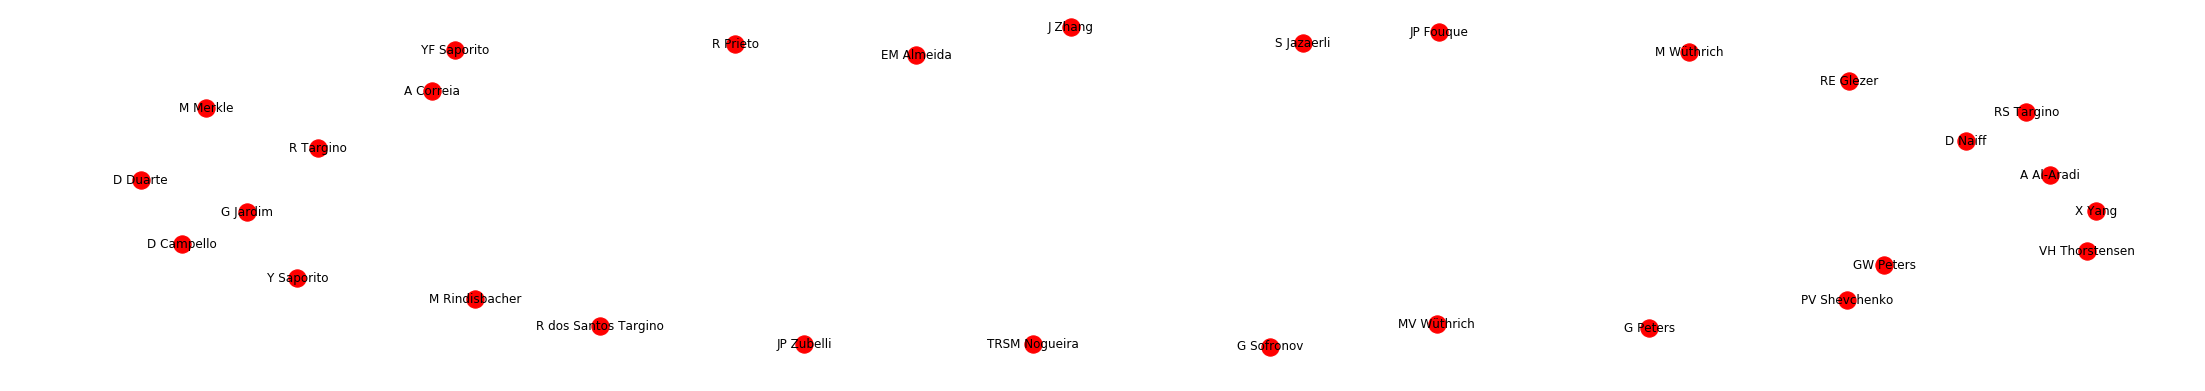

In [59]:
plt.figure(figsize=(30,5))
labels_author=dict((n,d['author_name']) for n,d in G_authors.nodes(data=True))
nx.draw_spring(G_authors,labels=labels_author,with_labels=True)

In [60]:
# Inserir as arestas
for d in count_authors.to_dict('records'):
    G_authors.add_edge(d['author1'],d['author2'],count = d['paper'])
    
for d in count_papers.to_dict('records'):
    G_papers.add_edge(d['paper1'],d['paper2'],count = d['author'])

/home/davi/Envs/datascience/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


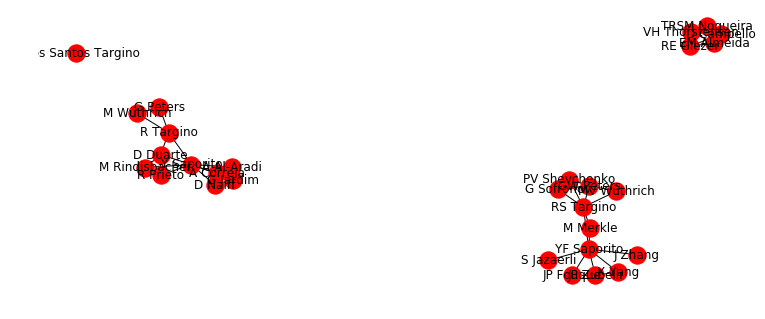

In [61]:
plt.figure(figsize=(10,4))
nx.draw_spring(G_authors,with_labels=True,labels=labels_author)

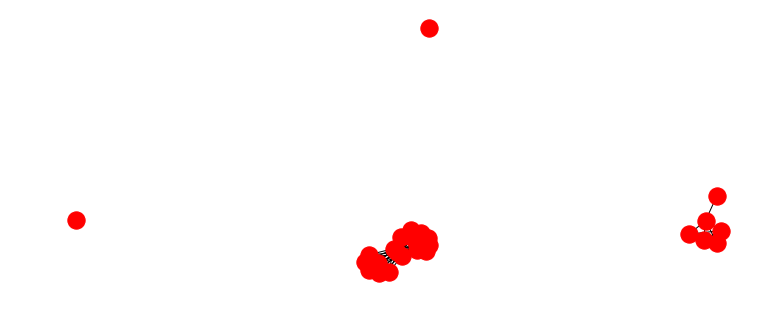

In [62]:
labels_paper =dict((n,d['paper_name']) for n,d in G_papers.nodes(data=True))
plt.figure(figsize=(10,4))
nx.draw_spring(G_papers,with_labels=False,labels=labels_paper)

# Utilizando Altair 
Funções obtidas de https://github.com/Zsailer/nx_altair/blob/master/nx_altair/core.py

In [66]:
def to_pandas_nodes(G, pos):
    """Convert Graph nodes to pandas DataFrame that's readable to Altair.
    """
    # Get all attributes in nodes
    attributes = ['x', 'y']
    for n in G.nodes():
        attributes += list(G.nodes[n].keys())
    attributes = list(set(attributes))

    # Build a dataframe for all nodes and their attributes
    df = pd.DataFrame(
        index=G.nodes(),
        columns=attributes
    )

    # Add node data to dataframe.
    for n in G.nodes:
        data = dict(
            x=pos[n][0],
            y=pos[n][1],
            **G.nodes[n]
        )
        df.loc[n] = data

    return df

def to_pandas_edges(G, pos, **kwargs):
    """Convert Graph edges to pandas DataFrame that's readable to Altair.
    """
    # Get all attributes in nodes
    attributes = ['source', 'target', 'x', 'y', 'edge', 'pair']
    for e in G.edges():
        attributes += list(G.edges[e].keys())
    attributes = list(set(attributes))


    # Build a dataframe for all edges and their attributes
    df = pd.DataFrame(
        index=range(G.size()*2),
        columns=attributes
    )


    # Add node data to dataframe.
    for i, e in enumerate(G.edges):
        idx = i*2

        data1 = dict(
            edge=i,
            source=e[0],
            target=e[1],
            pair=e,
            x=pos[e[0]][0],
            y=pos[e[0]][1],
            **G.edges[e]
        )

        data2 = dict(
            edge=i,
            source=e[0],
            target=e[1],
            pair=e,
            x=pos[e[1]][0],
            y=pos[e[1]][1],
            **G.edges[e]
        )

        df.loc[idx] = data1
        df.loc[idx+1] = data2

    return df

In [70]:
pos = nx.spring_layout(G_authors)
df_nodes_authors = to_pandas_nodes(G_authors,pos)
df_edges_authors = to_pandas_edges(G_authors,pos)

In [71]:
df_nodes_authors

,author_name,y,x
1,D Duarte,0.627648,0.0786849
2,G Peters,0.795417,0.0706664
3,G Sofronov,-0.400269,0.359433
4,GW Peters,-0.45112,0.404361
5,M Merkle,-0.520472,0.255495
6,M Wüthrich,0.808697,0.123902
7,MV Wüthrich,-0.50813,0.413683
8,PV Shevchenko,-0.401598,0.403998
9,R Targino,0.70567,0.108032
10,R dos Santos Targino,-0.143688,-1


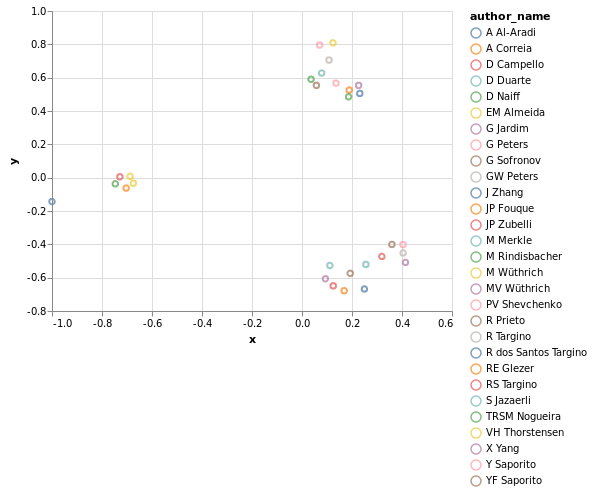

In [72]:
alt.Chart(df_nodes_authors).mark_point().encode(
    x = 'x',
    y = 'y',
    color = 'author_name'
)